# ML 101. Учимся работе с данными - от загрузки до моделирования
Цель: В этом домашнем задании вам предстоит поработать с достаточно небольшим, но интересным датасетом по раку груди. Признаками в этом наборе данных являются различные измерения образований в груди, такие как радиус, симметричность, и т.д. Целевая переменная - диагноз, является ли новообразование злокачественным или нет.

## Часть 1. EDA

1. Скачайте датасет по ссылке: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data
2. Посмотрите на базовые статистики датасета: средние, медианы, и т.д.
3. Постройте гистограммы/распределения признаков, при этом используйте целевую переменную, чтобы сгруппировать и раскрасить гистограммы
4. Постройте heatmap для матрицы корреляций, есть ли признаки, которые сильно скоррелированы? Какие это признаки?
5. Постройте для сильно скоррелированных признаков попарные scatterplot-ы, действительно ли наблюдается линейная зависимость?
6. Используя boxplots и группировку по целевой переменной, попробуйте предположить, по каким признакам наиболее удобно было бы отделить злокачественные новообразования от доброкачественных

## Часть 2. Моделирование при помощи kNN

1. Разбейте данные на train-test, отложив 30% выборки для тестирования
2. Приведите все непрерывные переменные к одному масштабу при помощи стандартизации. Кратко поясните, почему стандартизация здесь нужна
3. Постройте модель kNN "из коробки" без настройки параметров. Оцените метрики качества бинарной классификации (accuracy, precision, recall, f1_score), постройте ROC-кривую и посчитайте площадь под ней
4. Теперь проведите настройку параметра числа соседей на кросс-валидации. Снова оцените результаты, стало ли лучше? :)
5. Бонусное задание для любопытствующих, к которому можно вернуться после изучения логистической регрессии:
	1. Как вы помните, логистическая регрессия плохо относится к линейно-зависимым признакам, уберите переменные, корреляция пирсона между которыми превышает 0.85
	2. Постройте модель логистической регрессии "из коробки" без настройки параметров. Оцените метрики качества бинарной классификации (accuracy, precision, recall, f1_score), постройте ROC-кривую и посчитайте площадь под ней. Визуализируйте влияние коэффициентов на целевую переменную.
	3. Теперь проведите настройку параметра регуляризации C на кросс-валидации (LogisticRegressionCV). Снова оцените результаты и постройте визуализацию влияния коэффициентов на целевую переменную. Сделайте интересные выводы :)
	4. Какая из двух настроенных моделей, kNN или логистическая регрессия оказалась, в итоге, лучше?
    

## Критерии оценки
* EDA с базовыми визуализациями, scatterplot-ами и boxplot-ами - 5 баллов
* Предобработка датасета для обучения модели - 1 балл
* Обучение kNN, проверка качества и настройка гиперпараметров - 4 балла

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

%matplotlib inline

## Часть 1. EDA
### 1.1 Загрузка данных

Загружаем данные из датасета

In [2]:
data = pd.read_csv('datasets_180_408_data.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Столбец 32 выглядит лишним, стоит его удалить.
Поле id также не выглядит чем-то полезным.

In [4]:
data.drop('Unnamed: 32', axis=1, inplace=True)
data.drop('id', axis=1, inplace=True)

Получение базовых статистик датасета: средние, медиана, персентили

In [5]:
data.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


### 1.2 Визуализация данных

Сперва построим гистограммы и графики плотности распределения признаков, группирую с использованием целевой переменной

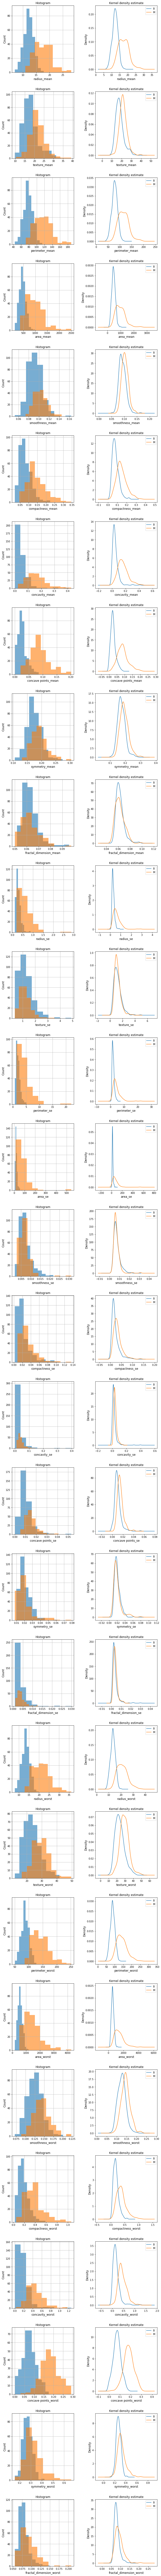

In [6]:
# Список колонок для построения графиков
columns = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 
           'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 
           'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 
           'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 
           'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 
           'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 
           'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']

# Группировка по целевой переменной
data_grouped = data.groupby("diagnosis")

# Создадим окружение для графиков, для каждой колонки два стобца
fig, axs = plt.subplots(nrows=len(columns), ncols=2, figsize=(10,150))

for index, column in enumerate(columns):
    # В первом столбце отобразим гистограмму, alpha=0.6 позволяет увидеть наложение
    data_grouped[column].hist(alpha=0.6, ax=axs[index, 0])
    axs[index, 0].set_title('Histogram')
    axs[index, 0].set_xlabel(column, fontsize=12)
    axs[index, 0].set_ylabel('Count', fontsize=12)

    # Во втором столбце отобразим график сглаженной плотности распределения на основе ядерной оценки
    data_grouped[column].plot(kind='kde', ax=axs[index, 1])
    axs[index, 1].set_title('Kernel density estimate')
    axs[index, 1].set_xlabel(column, fontsize=12)
    axs[index, 1].set_ylabel('Density', fontsize=12)
    axs[index, 1].legend()

plt.tight_layout(pad=3.0)
plt.show()

### 1.3 Визуализация корреляции

Теперь построим тепловую карту для матрицы корреляций

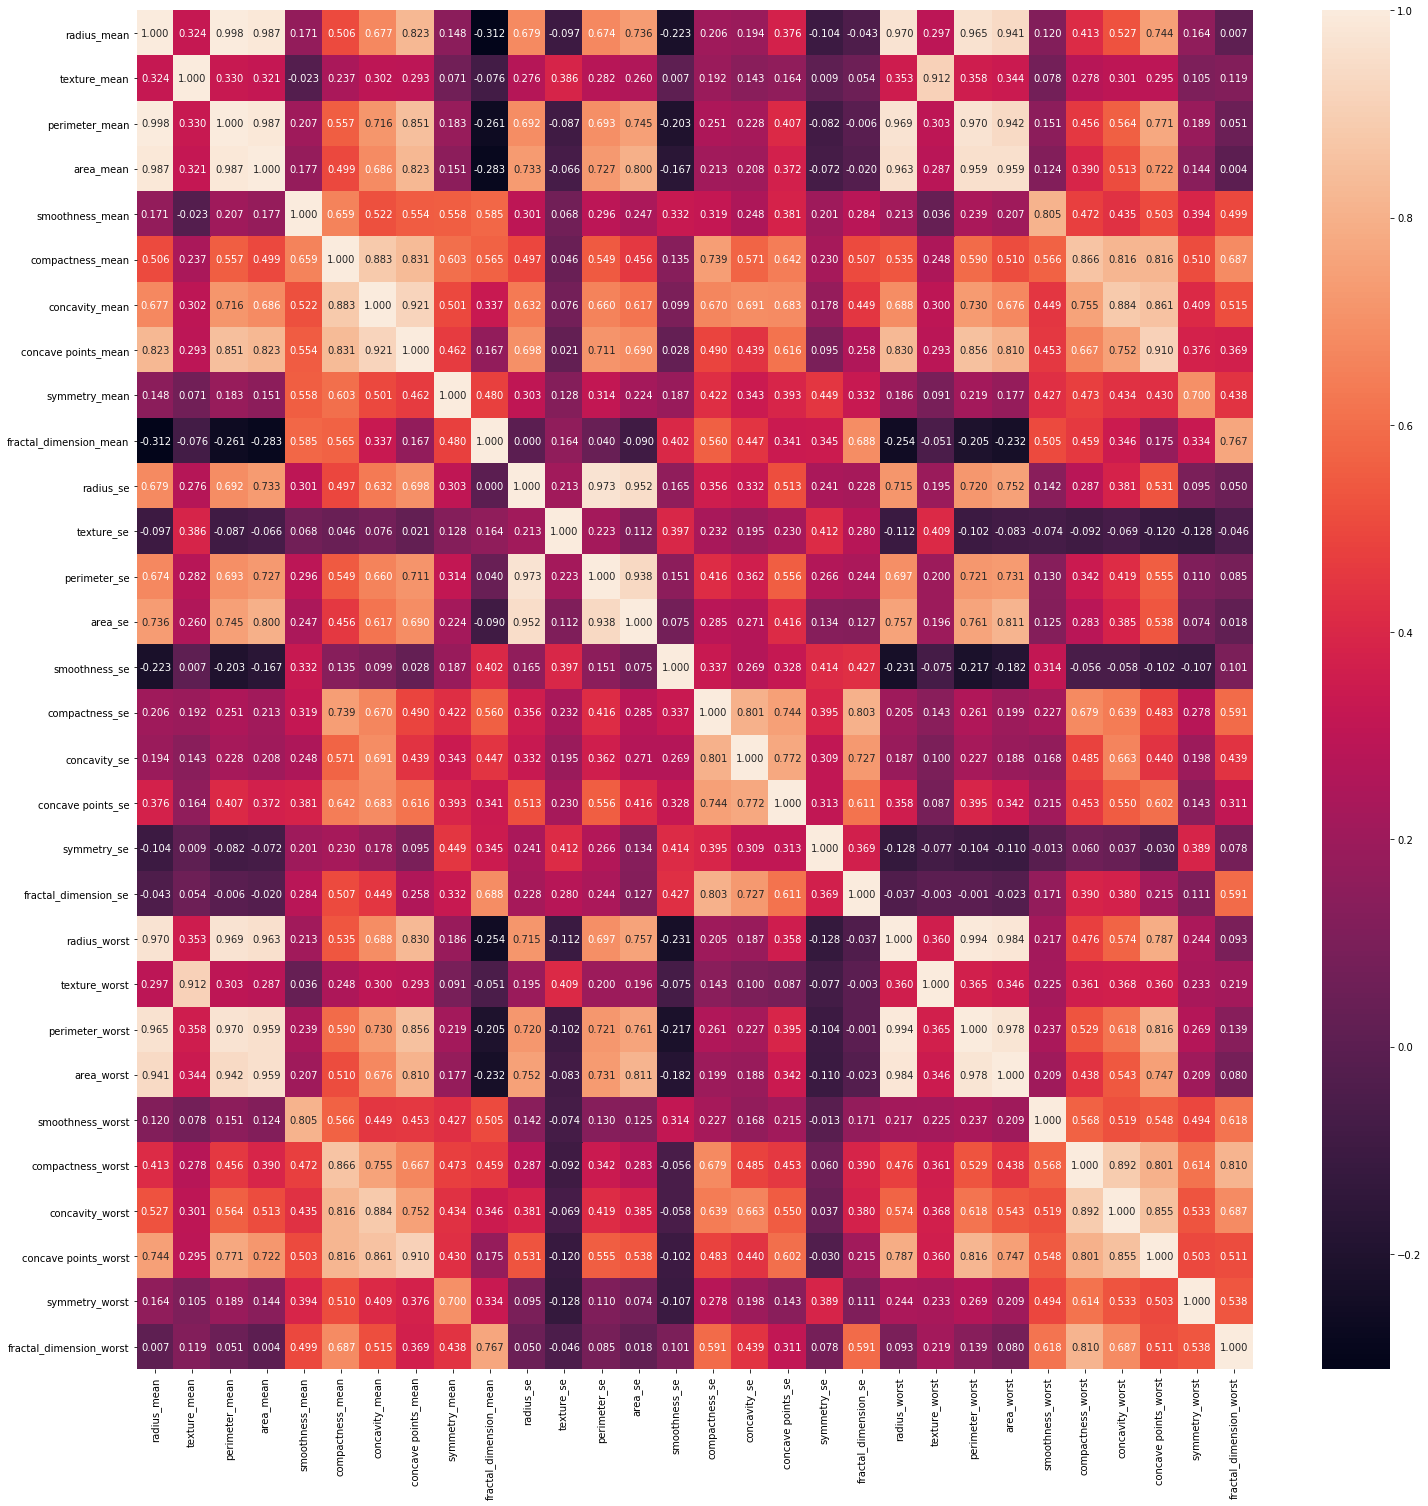

In [7]:
# Посчитаем матрицу корреляций для всех колонок
corr = data.corr()

# Отобразим ее на тепловой карте
plt.figure(figsize=(25,25));
sns.heatmap(corr, annot=True, fmt='.3f');

Исходя из тепловой карты можно понять, что некоторые признаки очень сильно скоррелированы:
* Средний радиус (**radius_mean**) сильно коррелирует со средним периметром (**perimeter_mean**, 0.998), площадью (**area_mean**, 0.987), количеством вогнутых точек (**concave points_mean**, 0.823) и с наибольшими значениями радиуса (**radius_worst**, 0.970), периметра (**perimeter_worst**, 0.965) и площади (**area_worst**, 0.941)
* Среднее значение текстур (**texture_mean**) сильно коррелирует с наибольшим значением (**texture_worst**, 0.912)
* Среднее значение по гладкости (**smoothness_mean**) сильно коррелирует с наибольшим значением (**smoothness_worst**, 0.805)
* Среднее значение компактности (**compactness_mean**) сильно коррелирует с худшим значением (**compactness_worst**, 0.866), а также со средним и наибольшим значением  вогнутости (**concavity_mean**, 0.883; **concavity_worst**, 0.816) и с худшим значением по количеству вогнутых точек (**concave points_worst**, 0.816)
* Среднее отклонение по радиусу сильно коррелирует со средними отклонениями по периметру (**perimeter_se**, 0.973) и площади (**area_se**, 0.952)
* Среднее отклонение по компактности (**compactness_se**) сильно коррелирует со средними отклонениями по вогнутости (**concavity_se**, 0.801) и фрактальной размерности (**fractal_dimension_se**, 0.803)

Следующим шагом построим графики парных корреляций, действительно ли между признаками наблюдается линейная зависимость. Хотя стоит заметить, что некоторые признаки изначально являются зависимыми (например, радиус, периметр и площадь).

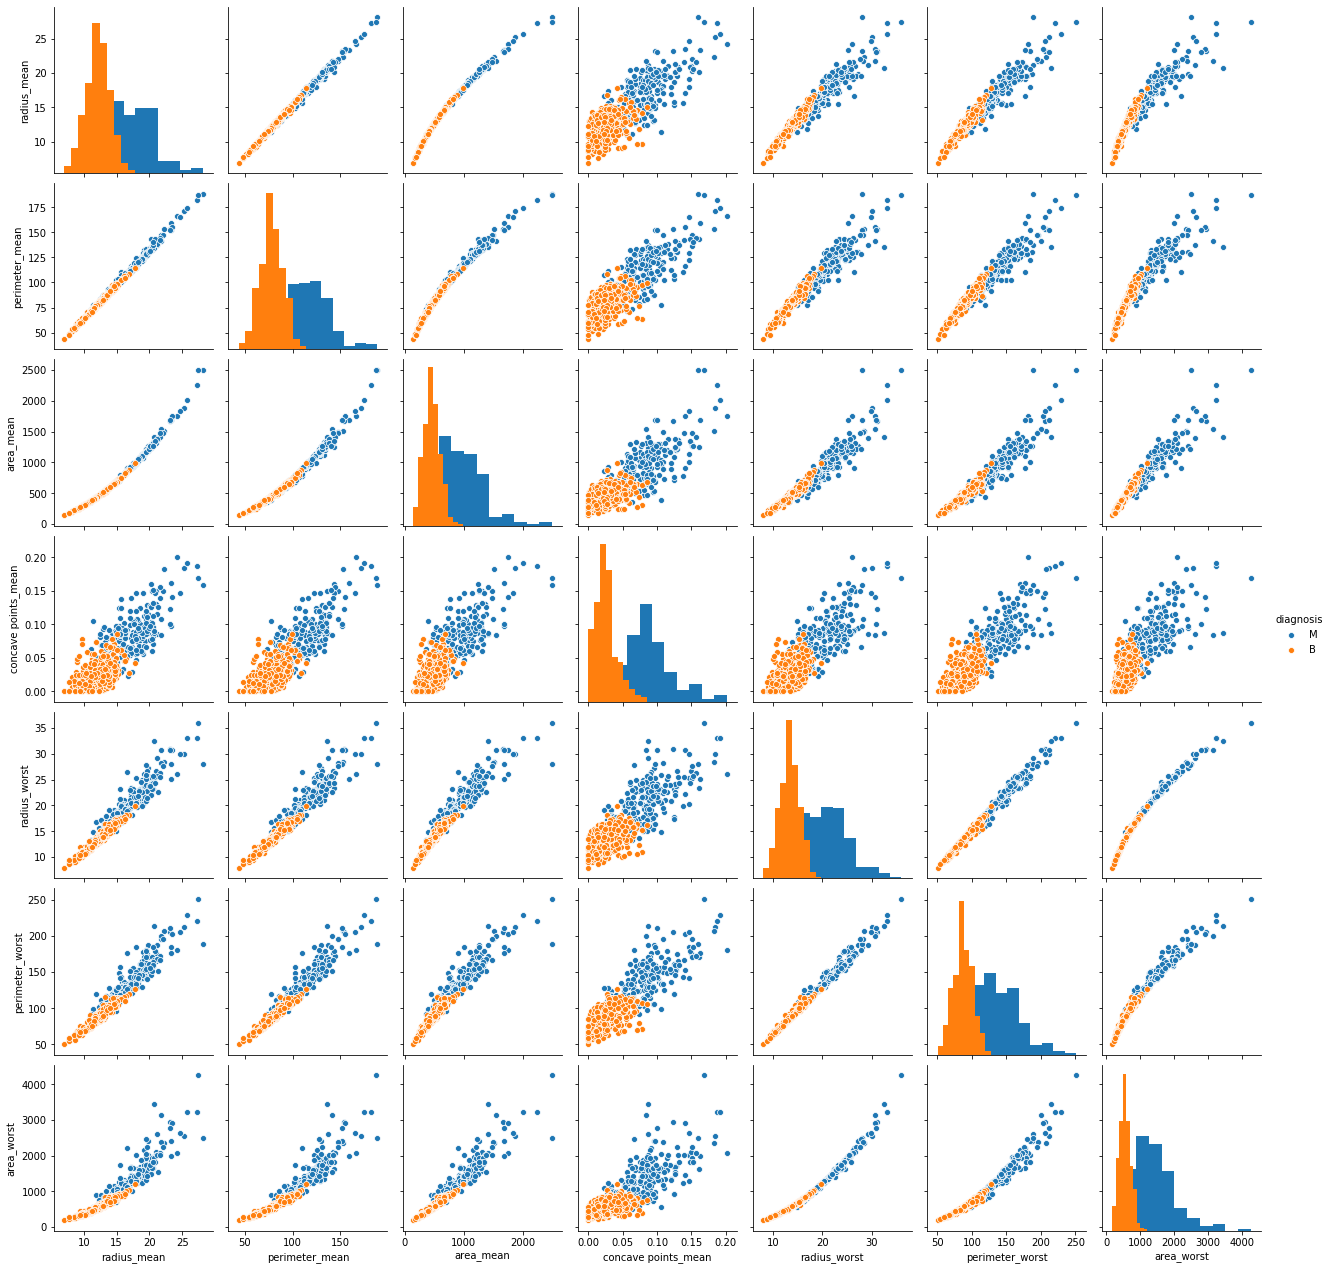

In [8]:
sns.pairplot(data[['diagnosis', 'radius_mean', 'perimeter_mean', 'area_mean', 'concave points_mean', 
                   'radius_worst', 'perimeter_worst', 'area_worst']], hue="diagnosis", diag_kind="hist");

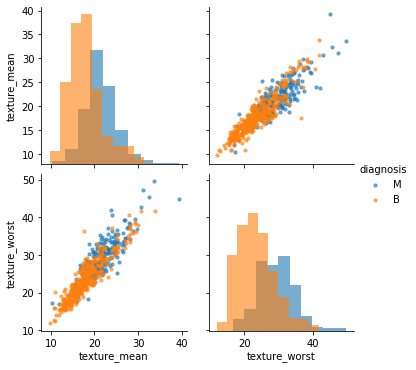

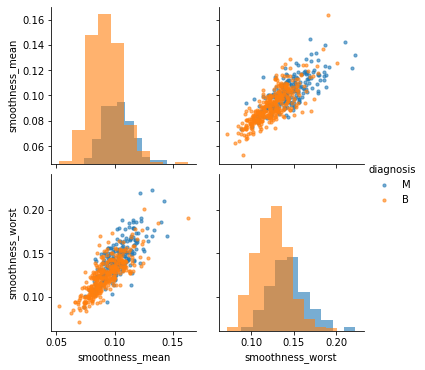

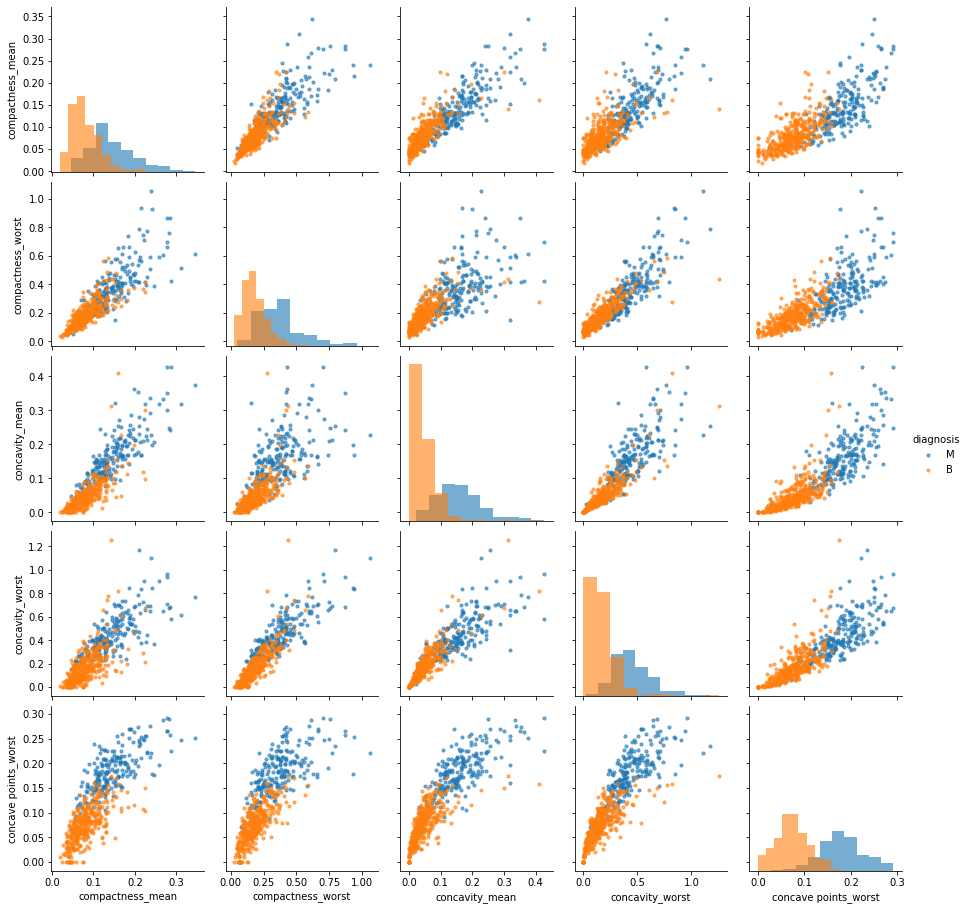

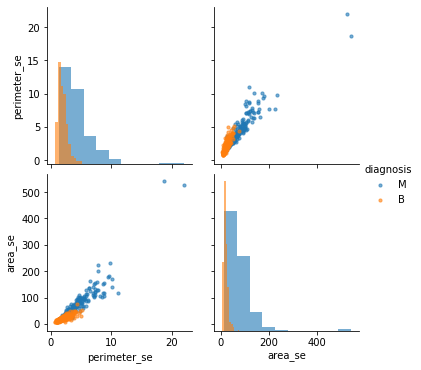

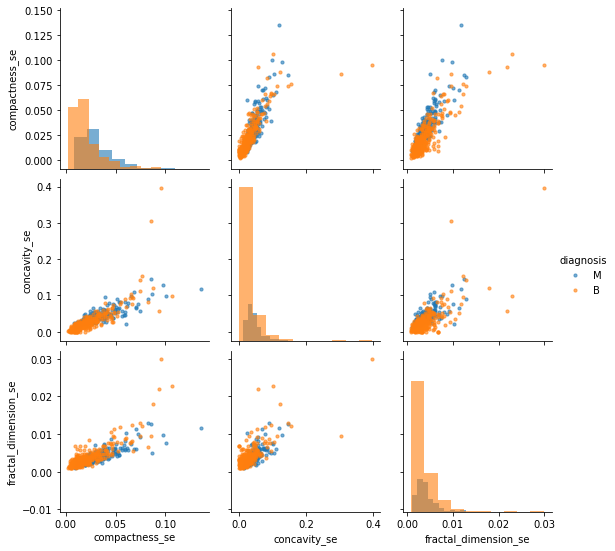

In [9]:
g = sns.PairGrid(data[['diagnosis', 'texture_mean', 'texture_worst']], hue="diagnosis")
g.map_diag(plt.hist, alpha=0.6)
g.map_offdiag(plt.scatter, s=10, alpha=0.6)
g.add_legend();

g = sns.PairGrid(data[['diagnosis', 'smoothness_mean', 'smoothness_worst']], hue="diagnosis")
g.map_diag(plt.hist, alpha=0.6)
g.map_offdiag(plt.scatter, s=10, alpha=0.6)
g.add_legend();

g = sns.PairGrid(data[['diagnosis', 'compactness_mean', 'compactness_worst', 'concavity_mean', 
                     'concavity_worst', 'concave points_worst']], hue="diagnosis")
g.map_diag(plt.hist, alpha=0.6)
g.map_offdiag(plt.scatter, s=10, alpha=0.6)
g.add_legend();

g = sns.PairGrid(data[['diagnosis', 'perimeter_se', 'area_se']], hue="diagnosis")
g.map_diag(plt.hist, alpha=0.6)
g.map_offdiag(plt.scatter, s=10, alpha=0.6)
g.add_legend();

g = sns.PairGrid(data[['diagnosis', 'compactness_se', 'concavity_se', 'fractal_dimension_se']], hue="diagnosis")
g.map_diag(plt.hist, alpha=0.6)
g.map_offdiag(plt.scatter, s=10, alpha=0.6)
g.add_legend();

plt.show()

### 1.4 Диаграммы размаха

Теперь посмотрим на диаграмму размаха, сгруппиров данные датафрейма по целевой переменной

/home/myslovets/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:375: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


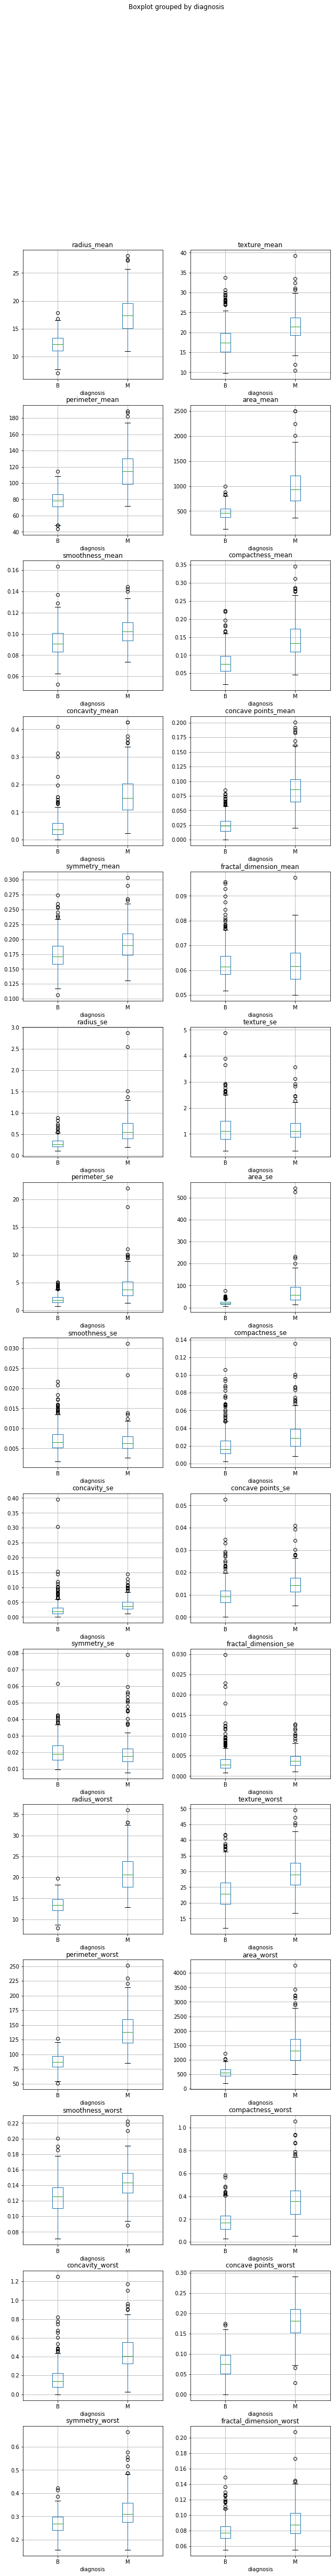

In [10]:
fig, axs = plt.subplots(nrows=15, ncols=2, sharex=False, sharey=False, figsize=(10,80))

data.boxplot(column=columns, by='diagnosis', ax=axs)

plt.show()

Судя по данным из графиков размаха можно выделить следующие признаки для использование в отделении злокачественных новообразований от доброкачественных:
* Радиус (radius_mean, radius_se and radius_worst)
* Текстура (texture_mean)
* Периметр (perimeter_mean, perimeter_se and perimeter_worst)
* Площадь (area_mean, area_se and area_worst)
* Компактность (compactness_mean and compactness_worst)
* Вогнутость (concavity_mean, concavity_se and concavity_worst)
* Вогнутые точки (concave points_mean, concave points_se and concave points_worst)

## Часть 2. Моделирование при помощи kNN

### 2.1 Подготовка данных

Сперва переведем все значения целевой переменной в 0 и 1, где отрицательный диагноз B - это 0, а положительный M - 1.

In [11]:
data['diagnosis'].unique()

array(['M', 'B'], dtype=object)

In [12]:
data.loc[data['diagnosis'] == 'M', 'diagnosis'] = 1
data.loc[data['diagnosis'] == 'B', 'diagnosis'] = 0

In [13]:
data['diagnosis'].unique()

array([1, 0], dtype=object)

Сохраним в $X$ все колонки признаки, а в $y$ $-$ целевую переменную.

In [14]:
X = np.array(data.drop('diagnosis', axis=1), dtype=pd.Series)
y = np.array(data['diagnosis'], dtype=pd.Series).astype('int')

X.shape, y.shape

((569, 30), (569,))

Разобьем данные на тренировочный и тестовый наборы.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((398, 30), (171, 30), (398,), (171,))

Можем заметить, что значения признаков имеют разный масштаб (например, радиус, площадь и компактность). Все признаки являются непрерывными переменными. Приведем их к одному масштабу.

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 2.2 Построение модели kNN без настройки параметра числа соседей

Построим модель kNN "из коробки" без настройки параметров.

In [18]:
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

Оценим качество бинарной классификации. Здесь
* **accuracy** - доля верно классифицированных объектов

$$Accuracy = \frac{TP + TN}{TP + FP + TN + FN}$$

* **precision** - точность

$$P = \frac{TP}{TP + FP}$$

* **recall** - полнота

$$R = \frac{TP}{TP + FN}$$

* **f1_score** - $f$-метрика

$$F = \frac{1}{\beta\frac{1}{P} + (1 - \beta)\frac{1}{R}}$$

In [19]:
accuracy = accuracy_score(y_pred, y_test)
print("Accuracy:  {:.3f}".format(accuracy))

precision = precision_score(y_pred, y_test)
print("Precision: {:.3f}".format(precision))

recall = recall_score(y_pred, y_test)
print("Recall:    {:.3f}".format(recall))

f1 = f1_score(y_pred, y_test)
print("F1-score:  {:.3f}".format(f1))

Accuracy:  0.959
Precision: 0.937
Recall:    0.952
F1-score:  0.944


#### ROC-кривая

Далее построим ROC-кривую и посчитаем площадь под ней (AUC).

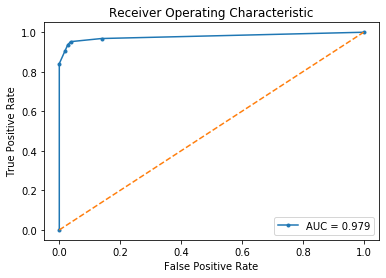

In [20]:
# Расчитаем вероятности классификации
probs = knn.predict_proba(X_test_scaled)
# Возьмем только положительные результаты
probs = probs[:, 1]

# Рассчитаем параметры для ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)

# Построим график
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, marker='.', label = 'AUC = %0.3f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 2.3 Настройка параметра числа соседей

Проведем настройку параметра числа соседей на кросс-валидации, используя GridSearchCV.

In [21]:
param_grid = {
    'n_neighbors': range(1, 50),
    'p': range(1, 4)
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_scaled, y_train)

print("Best CV f1-score: {:.3f}".format(grid_search.best_score_))
print("Best CV k:        {}".format(grid_search.best_estimator_.n_neighbors))

Best CV f1-score: 0.954
Best CV k:        5


In [22]:
test_predictions = grid_search.best_estimator_.predict(X_test_scaled)
print("Resulting test f1-score: {:.3f}".format(f1_score(test_predictions, y_test)))

Resulting test f1-score: 0.935


Построим ROC-кривую.

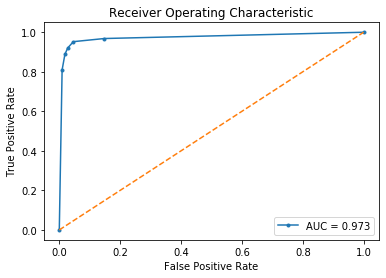

In [23]:
# Расчитаем вероятности классификации
probs = grid_search.best_estimator_.predict_proba(X_test_scaled)
# Возьмем только положительные результаты
probs = probs[:, 1]

# Рассчитаем параметры для ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)

# Построим график
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, marker='.', label = 'AUC = %0.3f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Как можем заметить, результаты изменились не особо.